### Vi prøver igen ...

- Alle data i en fil, vi korter i koden
- vi prøver med texts_to_matrix
- Jeg kan selv vælge hvad der er stort (kan prøve andet end 10), måske kan den lettere finde f.eks. 5?

### Konklusion
- Det er lykkedes at få det til at virke med een datafil, som indeholder både train og test
- Det er lykkedes at lave en opdeling på et vilkåligt tal i kode for stor og lille
- Data - som de er nu - har ikke ret megen struktur, det var også det jeg egentligt gættede på fra start. De rigtigt store kan modellen godt genkende, men rigtigt mange smutter bare igennem

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 10
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 10000)
(10867, 10000)
(90000,)
(10867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [16]:
NumEpochs = 20
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/20
81000/81000 [==============================] - 17s 211us/step - loss: 0.1190 - acc: 0.9687 - val_loss: 0.1531 - val_acc: 0.9586
Epoch 2/20
81000/81000 [==============================] - 16s 202us/step - loss: 0.1170 - acc: 0.9689 - val_loss: 0.1538 - val_acc: 0.9584
Epoch 3/20
81000/81000 [==============================] - 15s 189us/step - loss: 0.1151 - acc: 0.9695 - val_loss: 0.1524 - val_acc: 0.9582
Epoch 4/20
81000/81000 [==============================] - 15s 191us/step - loss: 0.1120 - acc: 0.9700 - val_loss: 0.1529 - val_acc: 0.9580
Epoch 5/20
81000/81000 [==============================] - 16s 196us/step - loss: 0.1107 - acc: 0.9706 - val_loss: 0.1517 - val_acc: 0.9581
Epoch 6/20
81000/81000 [==============================] - 16s 201us/step - loss: 0.1087 - acc: 0.9707 - val_loss: 0.1514 - val_acc: 0.9579
Epoch 7/20
81000/81000 [==============================] - 16s 199us/step - loss: 0.1069 - acc: 0.9711 - val_loss: 0.1

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [18]:
import matplotlib.pyplot as plt
plt.show()

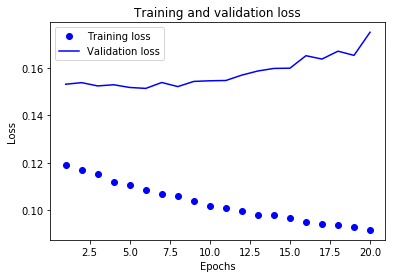

In [19]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

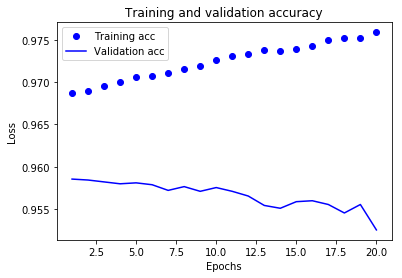

In [20]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [21]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

In [22]:
# finder ud af hvor stor en del store, som er fundet
print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     380.0
antal estimeret af modellen:  51
Modellens præcision:          13.0 %


In [23]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.2348994
0.03269141


In [24]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data, vi ser hvordan de predicter:')
print('-'*40)
print('Lines Predict Text')
for i in range(1,900):
    if labels_test[i]==1:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Jeg printer nogle liner som er sande i test data:
----------------------------------------
Lines Predict Text
   13  0.6233  Alle 40/41xx tog aflyses idag d 03/01-2011.
   18  0.0658  Fejl i spor. Bump i hovedsporet. 1. hv.sp. lukkes ned Kh-Kk.
   15  0.0175  materieldisponering manglende materiel  og nedformeringer fra sverige
   10  0.0303  Lki melder at togsæt kun kører på 1 anlæg, som er begyndt at melde om at det bliver for varmt, vi st
   10  0.0100  FOKUS på IC / EC, flygtninge.
   33  0.8575  Skinnebruddet Lj - Ro fortsætter. Prognosen siger til kl. 18 nu. Der er fundet et svejsehold.
   17  0.7856  Signalfejl: Alle blok afsnit mellem Lk og Es er gået ned og der bliver kørt på sigt.
   13  0.3832  MANGLENDE FJERNSTYRING Hr  del 2  Der kan ikke køre tog Hr - Bb - Hr  Der indsættes en stamm
   16  0.0005  Materielfejl MQ : halv motor kraft, utæt for kølevand
   17  0.0084  delaflyst
   16  0.2229  Materielmangler ME/DD og ICED, to af hver, nedenstående aflysninger er rettet i all

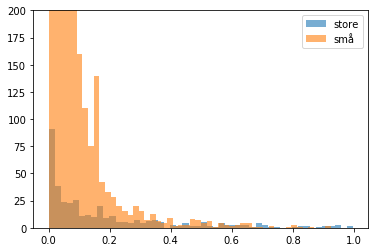

In [15]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

In [32]:
# hvilke tekster de forskellige typer består af
print('SANDE i test-sættet, som har SMÅ predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] < 0.05:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()
        
print('SANDE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

print('FALSKE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==0 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

SANDE i test-sættet, som har SMÅ predictions (men burde være store!):
----------------------------------------
Lines Predict Text
   15  0.0175  materieldisponering manglende materiel  og nedformeringer fra sverige
   10  0.0303  Lki melder at togsæt kun kører på 1 anlæg, som er begyndt at melde om at det bliver for varmt, vi st
   10  0.0100  FOKUS på IC / EC, flygtninge.
   16  0.0005  Materielfejl MQ : halv motor kraft, utæt for kølevand
   17  0.0084  delaflyst
   12  0.0124  Nedformeret fra Sverige
   15  0.0236  Der er en fastlægning på Kk, som ikke kan nå at gå i orden før 7, hvor det igen er muligt at få fat 
   14  0.0341  Har tabt luften i Gl, LKI er på sagen.
   11  0.0072  Materieldisponering i Helsingør
   10  0.0154  Mgl. materiel
   17  0.0052  Hærværk : Fik smadret rude da det passerede G 9234
   13  0.0168  KK ikke leveret ???
   13  0.0475  Mateirelfejl.1524 holder nedbrudt I røret
   11  0.0137  Mgl plads på Hgl
   13  0.0280  Materielfejl, defekt magnetbremse, nedbr

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...